In [30]:
import pandas as pd
import numpy as np
from numpy import unique
from numpy import argmax

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense

from keras.models import Sequential
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot

C:\Users\windy\AppData\Local\Temp\ipykernel_9256\423893486.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Czyszczenie i edycja bazy

In [53]:
data = pd.read_csv('PPR-R20PN20.csv', encoding= 'unicode_escape')

In [54]:
duplicated_rows= data[data.duplicated()]
print(duplicated_rows)

     SIGMA-LI     DateOf  cecha1  cecha2
28    PPR-20K  2/19/2010       6    1.08
37    PPR-20K   3/1/2010       0    0.00
39    PPR-20K   3/1/2010       0    0.00
40    PPR-20K   3/1/2010       0    0.00
49    PPR-20K   1/4/2011      10    2.10
...       ...        ...     ...     ...
2695  PPR-20K   4/3/2019       5    1.15
2697  PPR-20K  4/13/2019      10    2.30
2707  PPR-20K  5/11/2019      20    4.60
2714  PPR-20K  5/22/2019       4    0.92
2753  PPR-20K   8/6/2019     400   92.00

[381 rows x 4 columns]


In [55]:
data = data.drop_duplicates() #

In [56]:
cols_to_drop = ['SIGMA-LI']
data = data.drop(cols_to_drop, axis=1)

In [57]:
data2 = data.iloc[: , :-1]

In [58]:
data2['DateOf'] = pd.to_datetime(data2['DateOf'])
df2 = data2.groupby(data2['DateOf'].dt.to_period('w')).sum()

C:\Users\windy\AppData\Local\Temp\ipykernel_9256\2593112894.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = data2.groupby(data2['DateOf'].dt.to_period('w')).sum()


In [59]:
df2 = df2.reset_index()
df2['DateOf'] = df2['DateOf'].apply(lambda x: x.strftime('%Y-%m-%w'))
df2.set_index('DateOf', inplace=True)

In [60]:
df2.to_csv('R20PN20.csv')

PPR-20KD12: Wykres wielkości/ilości cechy1 i cecy 2

PPR-20KD12: Cecha

In [61]:
from datetime import datetime
def parser(x):
	return datetime.strptime(x,'%Y-%m-%w')

In [62]:
series = read_csv('R20PN20.csv', header=0, parse_dates=[0], squeeze=True, date_parser=parser)
series = series.iloc[: , 1]

C:\Users\windy\AppData\Local\Temp\ipykernel_9256\973500060.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('20k.csv', header=0, parse_dates=[0], squeeze=True, date_parser=parser)


In [63]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(df2, lag=1):
	df = DataFrame(df2)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [64]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [65]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [66]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [67]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [68]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [69]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [70]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [71]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [72]:
# split data into train and test-sets
train, test = supervised_values[0:-52], supervised_values[-52:]

In [73]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [74]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 812, 1)

In [75]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

424/424 [==============================] - 3s 2ms/step


array([[-4.79565442e-01],
       [-8.30889642e-02],
       [ 4.30625677e-02],
       [ 6.43647313e-02],
       [ 7.98667669e-02],
       [ 6.85929060e-02],
       [ 6.29372597e-02],
       [-7.96477795e-02],
       [-4.79582965e-01],
       [ 2.98739672e-02],
       [ 3.81039381e-02],
       [-4.45793271e-02],
       [-5.93954325e-03],
       [-3.09854448e-01],
       [-2.43817568e-02],
       [-4.66391355e-01],
       [ 3.16874385e-02],
       [ 2.54688263e-02],
       [-2.27058470e-01],
       [-1.79080397e-01],
       [ 5.26969433e-02],
       [ 3.54576111e-02],
       [-2.91135728e-01],
       [-3.95773709e-01],
       [ 7.21192360e-03],
       [ 1.32158995e-02],
       [ 5.88962436e-02],
       [-4.29901361e-01],
       [-3.21734548e-02],
       [-2.59111971e-01],
       [-1.58746123e-01],
       [ 6.75362349e-02],
       [ 2.55140662e-02],
       [-2.16006219e-01],
       [ 2.97915936e-02],
       [-8.23957324e-02],
       [-1.23359680e-01],
       [ 9.89433527e-02],
       [ 8.8

In [76]:
# repeat experiment
repeats = 10
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 812, 1)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-52:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

              rmse
count    10.000000
mean   1812.777581
std    3327.490377
min     240.464373
25%     245.144397
50%     248.110688
75%     250.513303
max    8949.257554


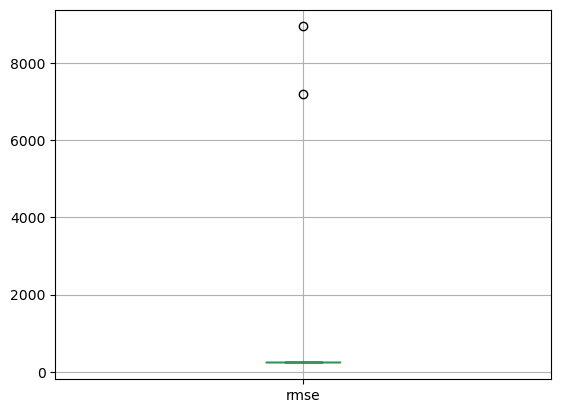

In [ ]:
#summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-52:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 249.224


In [ ]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Week=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 59ms/step
Week=1, Predicted=-552.857213, Expected=200.000000
1/1 [==============================] - 0s 94ms/step
Week=2, Predicted=30.334107, Expected=250.000000
1/1 [==============================] - 0s 61ms/step
Week=3, Predicted=221.072820, Expected=220.000000
1/1 [==============================] - 0s 93ms/step
Week=4, Predicted=300.105450, Expected=416.000000
1/1 [==============================] - 0s 51ms/step
Week=5, Predicted=338.517344, Expected=200.000000
1/1 [==============================] - 0s 51ms/step
Week=6, Predicted=379.987529, Expected=230.000000
1/1 [==============================] - 0s 61ms/step
Week=7, Predicted=366.217969, Expected=572.000000
1/1 [==============================] - 0s 50ms/step
Week=8, Predicted=372.206216, Expected=200.000000
1/1 [==============================] - 0s 61ms/step
Week=9, Predicted=412.498399, Expected=26.000000
1/1 [==============================] - 0s 51ms/step
Week=10, Predicted=298.345731, 

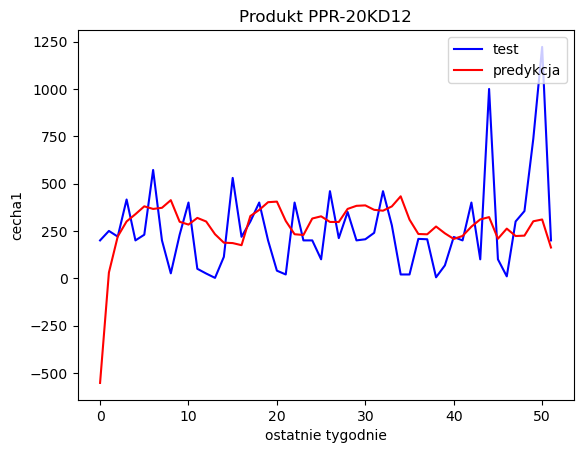

In [ ]:
# line plot of observed vs predicted, last ... m
pyplot.plot(raw_values[-52:], color='blue', label='test')
pyplot.plot(predictions, color='red', label='predykcja')
pyplot.xlabel('ostatnie tygodnie')
pyplot.ylabel('cecha1')
pyplot.title('Produkt PPR-R20PN20')
pyplot.legend(loc='upper right')
pyplot.show()

b=raw_values[-52:]